<a href="https://colab.research.google.com/github/a-pujahari/EVA7/blob/main/Session5/EVA7_Session_5_Drill_Down_Part_5_Augmentations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# Target
1. Add data augmentations to improve overall testing accuracy.

Based on analysis of wrong predictions in the last step, random rotations, random affine transormations and Color jitter augmentations have been added.

Color jitter may not contribute much beyond differences in contrast and visibility of numbers within images.

# Results
Total parameters: 7,624

Best Training Accuracy: 97.63% - 15th Epoch

Best Testing Accuracy: 99.34% - 13th Epoch

# Analysis

Underfitting is clearly evident, training accuracy is consistently lower than testing accuracy. However, testing accuracy numbers are up and are close to our target of 99.4%.

Using the right learning rate scheduler can help maximize testing accuracy and help reach our target with the required consistency.

## Specify Data Transformations

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.RandomAffine(degrees=7, shear=10, translate=(0.1, 0.1), scale=(0.8, 1.2)),
                                       transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.40, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

## Download Dataset & Specify Transformations

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Device & Dataloader Specifications

In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? False


## Model

In [5]:
dropout_value = 0.05


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), ## Expand number of channels
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.transblock1 = nn.Sequential(
            nn.MaxPool2d(2,2), ## Squeeze
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False), ## Pointwise Convolution
        ) # output_size = 12
        #self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), ## Expand number of channels
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 10

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=24, kernel_size=(3, 3), padding=0, bias=False), ## Expand number of channels
            nn.ReLU(),
            nn.BatchNorm2d(24),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=8) ## Global Average Pooling
        ) # output_size = 1

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=24, out_channels=32, kernel_size=(1, 1), padding=0, bias=False), ## Increase (expand) number of channels
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        )

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1, 1), padding=0, bias=False), ## Reduce down number of channels
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) 

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False), ## Reduce number of channels to output required
        ) 


    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.transblock1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.gap(x)        
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

## Model Summary

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]             128
           Conv2d-11           [-1, 16, 10, 10]           1,152
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


## Define Train & Test Functions

In [7]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

## Train & Test Model

In [8]:
from torch.optim.lr_scheduler import StepLR, ExponentialLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.95)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch + 1)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 1


Loss=0.4399264454841614 Batch_id=937 Accuracy=83.67: 100%|██████████| 938/938 [01:20<00:00, 11.71it/s]



Test set: Average loss: 0.0728, Accuracy: 9778/10000 (97.78%)

EPOCH: 2


Loss=0.12073969095945358 Batch_id=937 Accuracy=94.51: 100%|██████████| 938/938 [01:19<00:00, 11.76it/s]



Test set: Average loss: 0.0407, Accuracy: 9880/10000 (98.80%)

EPOCH: 3


Loss=0.166791632771492 Batch_id=937 Accuracy=95.71: 100%|██████████| 938/938 [01:19<00:00, 11.79it/s]



Test set: Average loss: 0.0367, Accuracy: 9886/10000 (98.86%)

EPOCH: 4


Loss=0.31214675307273865 Batch_id=937 Accuracy=96.51: 100%|██████████| 938/938 [01:19<00:00, 11.81it/s]



Test set: Average loss: 0.0315, Accuracy: 9891/10000 (98.91%)

EPOCH: 5


Loss=0.22921814024448395 Batch_id=937 Accuracy=96.69: 100%|██████████| 938/938 [01:19<00:00, 11.75it/s]



Test set: Average loss: 0.0288, Accuracy: 9900/10000 (99.00%)

EPOCH: 6


Loss=0.08004957437515259 Batch_id=937 Accuracy=96.90: 100%|██████████| 938/938 [01:20<00:00, 11.71it/s]



Test set: Average loss: 0.0260, Accuracy: 9909/10000 (99.09%)

EPOCH: 7


Loss=0.13495159149169922 Batch_id=937 Accuracy=96.94: 100%|██████████| 938/938 [01:19<00:00, 11.79it/s]



Test set: Average loss: 0.0285, Accuracy: 9905/10000 (99.05%)

EPOCH: 8


Loss=0.11575966328382492 Batch_id=937 Accuracy=97.10: 100%|██████████| 938/938 [01:19<00:00, 11.78it/s]



Test set: Average loss: 0.0251, Accuracy: 9923/10000 (99.23%)

EPOCH: 9


Loss=0.1865098625421524 Batch_id=937 Accuracy=97.28: 100%|██████████| 938/938 [01:19<00:00, 11.79it/s]



Test set: Average loss: 0.0247, Accuracy: 9920/10000 (99.20%)

EPOCH: 10


Loss=0.06182382255792618 Batch_id=937 Accuracy=97.23: 100%|██████████| 938/938 [01:19<00:00, 11.84it/s]



Test set: Average loss: 0.0243, Accuracy: 9919/10000 (99.19%)

EPOCH: 11


Loss=0.04400036484003067 Batch_id=937 Accuracy=97.48: 100%|██████████| 938/938 [01:20<00:00, 11.64it/s]



Test set: Average loss: 0.0254, Accuracy: 9920/10000 (99.20%)

EPOCH: 12


Loss=0.21762043237686157 Batch_id=937 Accuracy=97.48: 100%|██████████| 938/938 [01:21<00:00, 11.52it/s]



Test set: Average loss: 0.0214, Accuracy: 9928/10000 (99.28%)

EPOCH: 13


Loss=0.05094878375530243 Batch_id=937 Accuracy=97.48: 100%|██████████| 938/938 [01:21<00:00, 11.48it/s]



Test set: Average loss: 0.0220, Accuracy: 9934/10000 (99.34%)

EPOCH: 14


Loss=0.020398331806063652 Batch_id=937 Accuracy=97.66: 100%|██████████| 938/938 [01:21<00:00, 11.55it/s]



Test set: Average loss: 0.0231, Accuracy: 9922/10000 (99.22%)

EPOCH: 15


Loss=0.1090070828795433 Batch_id=937 Accuracy=97.63: 100%|██████████| 938/938 [01:21<00:00, 11.49it/s]



Test set: Average loss: 0.0204, Accuracy: 9932/10000 (99.32%)



## Training & Testing Loss Curves

Text(0.5, 1.0, 'Test Accuracy')

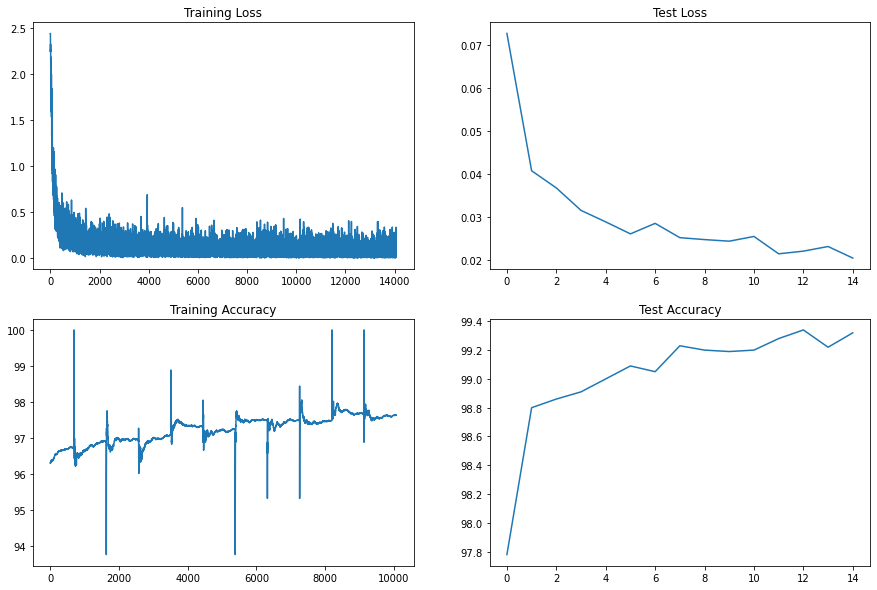

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")